In [86]:
import torch
import pickle, gzip
import torch.nn.functional as F 
import re
import matplotlib.pyplot as plt

from fastai import datasets
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'


In [87]:
from typing import *
# This function handles emty list and stuff in them. 

def listify(o):
    if o is None: 
        return []
    if isinstance(o, list): 
        return o
    if isinstance(o, str): 
        return [o]
    if isinstance(o, Iterable): 
        return list(o)
    return [o]

In [88]:
# This function gets the data from the URL, unpickles the data

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

In [89]:
# Dataset this function takes two list x and y. Here we update the dunder things and that us what we need! 
# Returns al ist of tulpes!
class Dataset():
    def __init__(self, x, y): 
        self.x,self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i],self.y[i]

In [90]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [91]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [92]:
# The data bunch takes the train and validato set togheter
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl=train_dl
        self.valid_dl=valid_dl
        self.c =c
        
    @property
    def train_ds(self): 
        return self.train_dl.dataset
        
    @property
    def valid_ds(self):
        return self.valid_dl.dataset

In [93]:
# The data loder takes the data and batch them! 
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            torch.utils.data.DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [94]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [95]:
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

In [96]:
#export
class Callback():
    _order=0
    def set_runner(self, run): 
        self.run=run
    def __getattr__(self, k): 
        return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): 
            return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: 
            return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): 
    pass
class CancelEpochException(Exception):
    pass
class CancelBatchException(Exception):
    pass

In [97]:
#export
from IPython import embed

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       
        return self.learn.opt
    @property
    def model(self):     
        return self.learn.model
    @property
    def loss_func(self): 
        return self.learn.loss_func
    @property
    def data(self):
        return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: 
                return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: 
            self('after_cancel_batch')
        finally: 
            self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [98]:
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model=model
        self.opt=opt
        self.loss_func=loss_func
        self.data =data

In [99]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

# Question? 

What is happening here, whats the diffrence between sending in a function with or without parenteses

- Sending a function without () menas we are sending int the function when using () we are calling the function and sending in what the functions returns! 

In [100]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = torch.nn.Sequential(torch.nn.Linear(m,nh), torch.nn.ReLU(), torch.nn.Linear(nh,data.c))
    return model, torch.optim.SGD(model.parameters(), lr=lr)

In [101]:
learn = create_learner(get_model, loss_func, data)
learn

In [102]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: 
            raise CancelTrainException()

In [103]:
run = Runner(cb_funcs=TestCallback)

In [104]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


In [105]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: 
            return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): 
        plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0):
        plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): 
        self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

## LR finder

In [106]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [107]:
learn = create_learner(get_model, loss_func, data)

In [108]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [109]:
run.fit(2, learn)

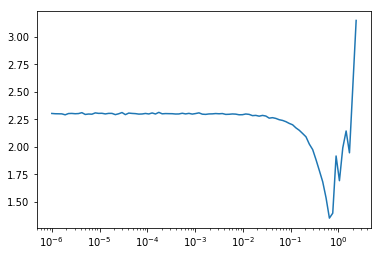

In [110]:
run.recorder.plot(skip_last=5)